## Self-Driving Car Engineer Nanodegree

** Vehicle Detection Project **


The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
3. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
4. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
5. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
6. Estimate a bounding box for vehicles detected.

### Set dependency

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os, sys 
sys.path.append('lib/')
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from vtcv.dataset import visualize_dataset as vd
from functools import partial
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import imageio
import time
import random
imageio.plugins.ffmpeg.download()
from multiprocessing import Pool

### Helper functions from the lecture

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return return_list

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' :
            color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Draw a rectangle given bbox coordinates
        else :
            c = color if color == 'random' else (random.randint(0,255),random.randint(0,255),random.randint(0,255))
            cv2.rectangle(imcopy, bbox[0], bbox[1], c, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Load pre-trained model

In [3]:
def load_model(path,mid) :
    with open('{}/feature_cfgs.pkl'.format(path), 'rb') as pkl_file :
        feature_config = pickle.load(pkl_file)
    fcfg = feature_config[mid]
    clf = joblib.load('{}/{}_model.clf'.format(path,mid))
    with open('{}/{}_X_scaler.pkl'.format(path,mid), 'rb') as pkl_file:
        X_scaler = pickle.load(pkl_file)
        
    return fcfg,clf,X_scaler

### Sliding window

In [4]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

## Sliding window types

In [5]:
search_space_window = []

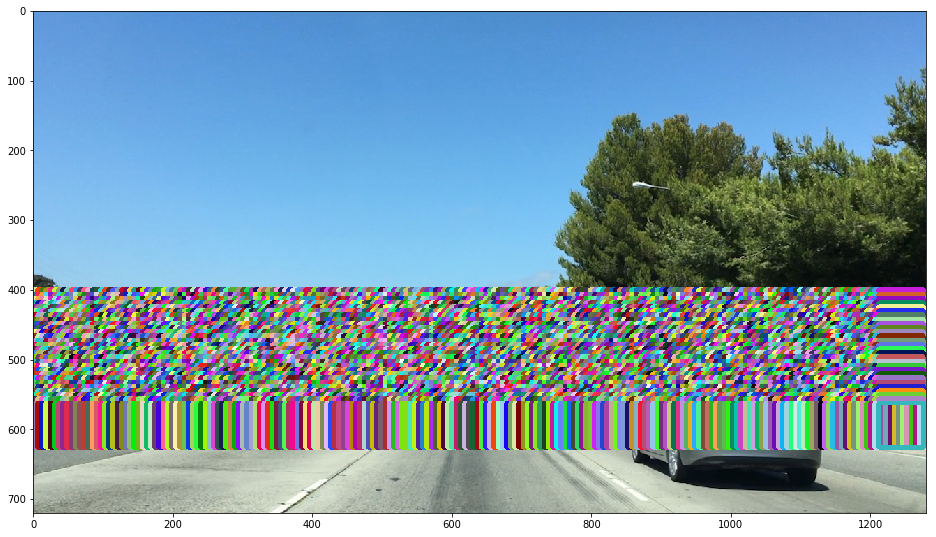

In [6]:
image = mpimg.imread('./test_images/bbox-example-image.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 630], 
            xy_window=(64, 64), xy_overlap=(0.9,0.9))

search_space_window = search_space_window + windows

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
fig = plt.figure(figsize=(16, 11))
plt.imshow(window_img)

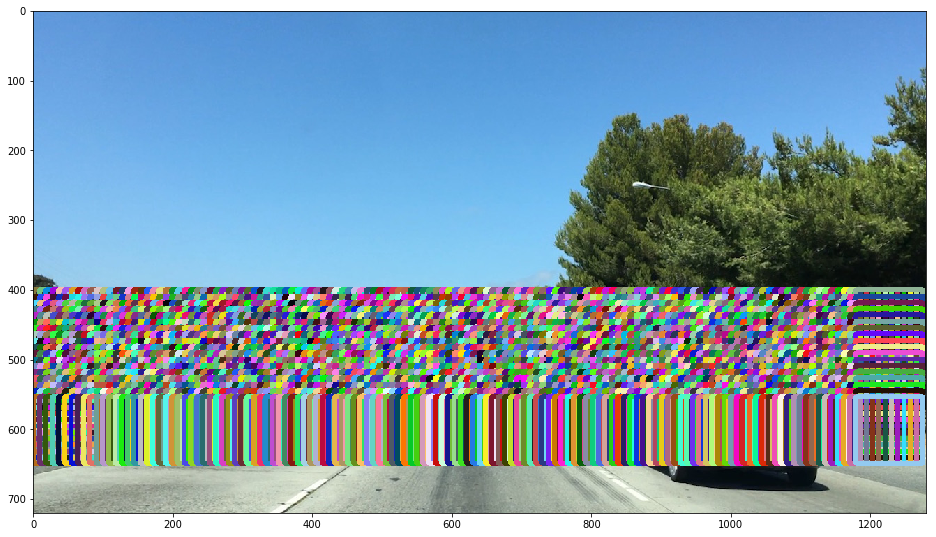

In [7]:
image = mpimg.imread('./test_images/bbox-example-image.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 650], 
            xy_window=(96, 96), xy_overlap=(0.9, 0.9))

search_space_window = search_space_window + windows

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
fig = plt.figure(figsize=(16, 11))
plt.imshow(window_img) 

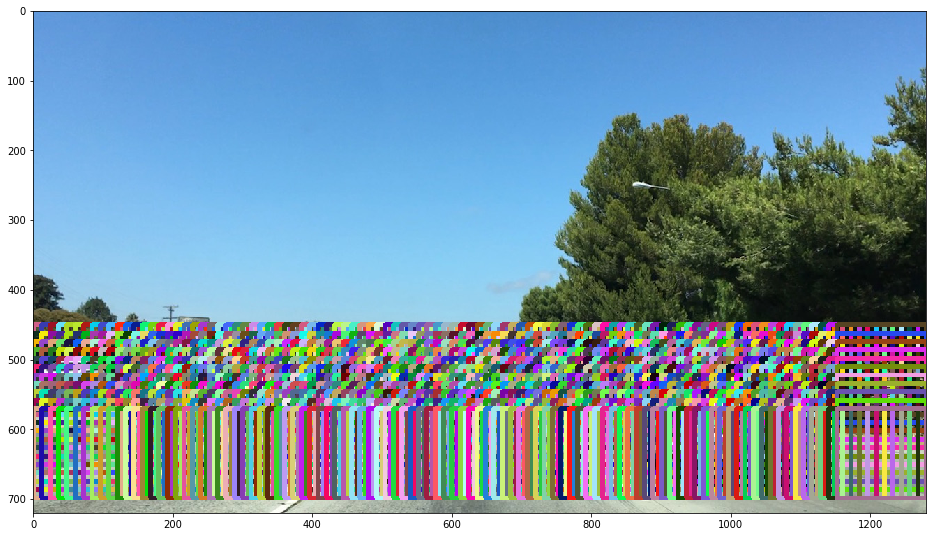

In [8]:
image = mpimg.imread('./test_images/bbox-example-image.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[450, 700], 
            xy_window=(128, 128), xy_overlap=(0.9, 0.9))
          
search_space_window = search_space_window + windows

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
fig = plt.figure(figsize=(16, 11))
plt.imshow(window_img)


In [9]:
'''
image = mpimg.imread('./test_images/bbox-example-image.jpg')
windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 760], 
            xy_window=(196, 196), xy_overlap=(0.9, 0.9))

search_space_window = search_space_window + windows

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
fig = plt.figure(figsize=(16, 11))
plt.imshow(window_img)
'''
print("")

In [10]:
'''
image = mpimg.imread('./test_images/bbox-example-image.jpg')
windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 760], 
            xy_window=(228, 228), xy_overlap=(0.9, 0.9))
                       
search_space_window = search_space_window + windows

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
fig = plt.figure(figsize=(16, 11))
plt.imshow(window_img)
'''
print("")

### Classify Cars

In [11]:
def extract_feature(img, fcfg) :
    features = []
    
    image = img # img.astype(np.float32)/255
    
    # apply color conversion if other than 'RGB'
    if fcfg['cspc'] != 'RGB':
        if fcfg['cspc'] == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif fcfg['cspc'] == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif fcfg['cspc'] == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif fcfg['cspc'] == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif fcfg['cspc'] == 'GRAY' :
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else: 
        feature_image = np.copy(image)

    if fcfg['ch'] == 'ALL' and len(feature_image.shape) == 3 :
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                fcfg['ori'], fcfg['ppc'], fcfg['cblk'], 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    else:
        if fcfg['cspc'] != 'GRAY' :
            hog_features = get_hog_features(feature_image[:,:,fcfg['ch']], 
                                fcfg['ori'], fcfg['ppc'], fcfg['cblk'],
                                vis=False, feature_vec=True)
        else :
            hog_features = get_hog_features(feature_image, 
                                fcfg['ori'], fcfg['ppc'], fcfg['cblk'],
                                vis=False, feature_vec=True)

    features.append(hog_features)
        
    return features

def classify(patch,fcfg,clf,scaler) :    
    feature = extract_features(patch, fcfg)
    X2predict = np.array(feature)
    fp = scaler.transform(X2predict)#.reshape(1,-1))
    prediction = clf.predict(fp)
    print (prediction)
    if prediction == 0 :
        print ("not car")
    else : 
        print ("car ")

In [12]:
def chunks(l, n):
    chunked_list = []
    step = int(len(l) / n)
    for i in range(0, len(l), step):
        chunked_list.append(l[i:i + step])
    return chunked_list

def search_windows(windows, img, clf1, scaler1, fcfg1) : 
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        feature1 = extract_feature(test_img, fcfg1)
        feature1 = np.array(feature1)
        #5) Scale extracted features to be fed to classifier
        feature1 = scaler1.transform(feature1)
        #6) Predict using your classifier
        prediction1 = clf1.predict(feature1)
        #7) If positive (prediction == 1) then save the window
        if prediction1 == 1 : 
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Test classifier

In [13]:
def detect_cars(frame, windows, clf1, X_scaler1, fcfg1, vis=False):
                       
    p = Pool(30)
    split_windows = chunks(windows,30)

    f = partial(search_windows,img=frame, clf1=clf1, scaler1=X_scaler1, fcfg1=fcfg1)
    mlt_prc = p.map_async(f,split_windows)

    hot_windows=[]

    for r in mlt_prc.get() :
        hot_windows = hot_windows + r
    
    p.close(),p.join()
    
    window_img = draw_boxes(frame, hot_windows, color='random', thick=2)                
    
    if vis :
        fig = plt.figure(figsize=(16, 11))
        plt.imshow(cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB))
    
    return hot_windows, window_img

In [14]:
fcfg1,clf1,X_scaler1 = load_model('models/svm_rbf',11)

In [15]:
len(search_space_window)

9127

# hot windows =  67
# hot windows =  59
# hot windows =  7
# hot windows =  0
# hot windows =  5
# hot windows =  105


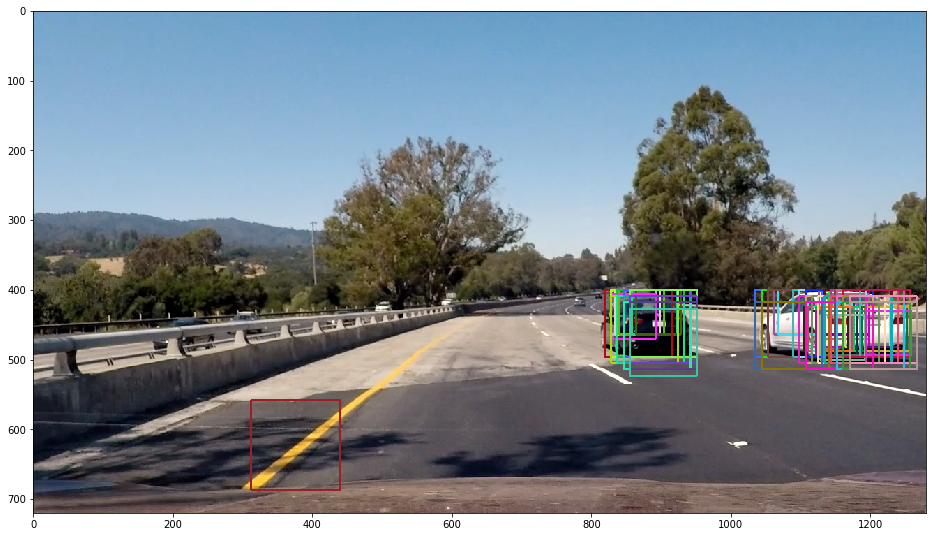

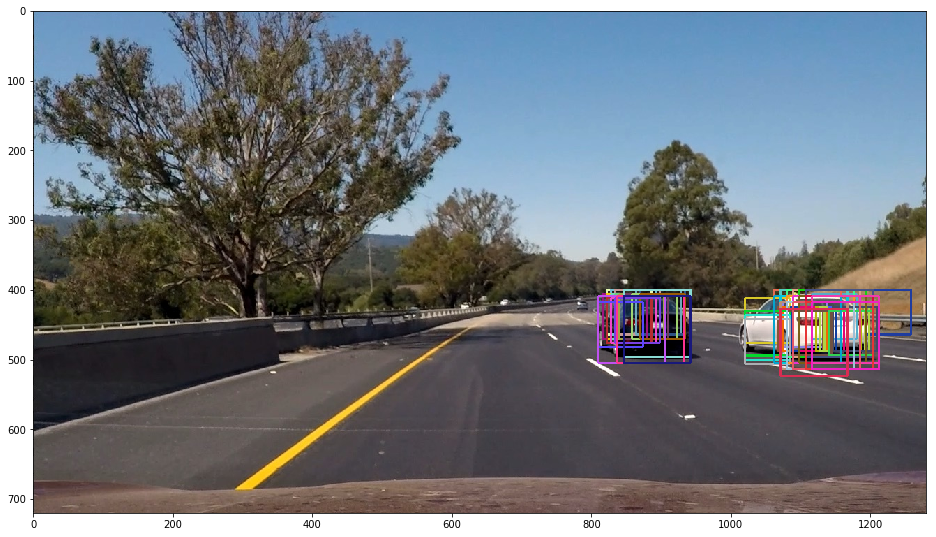

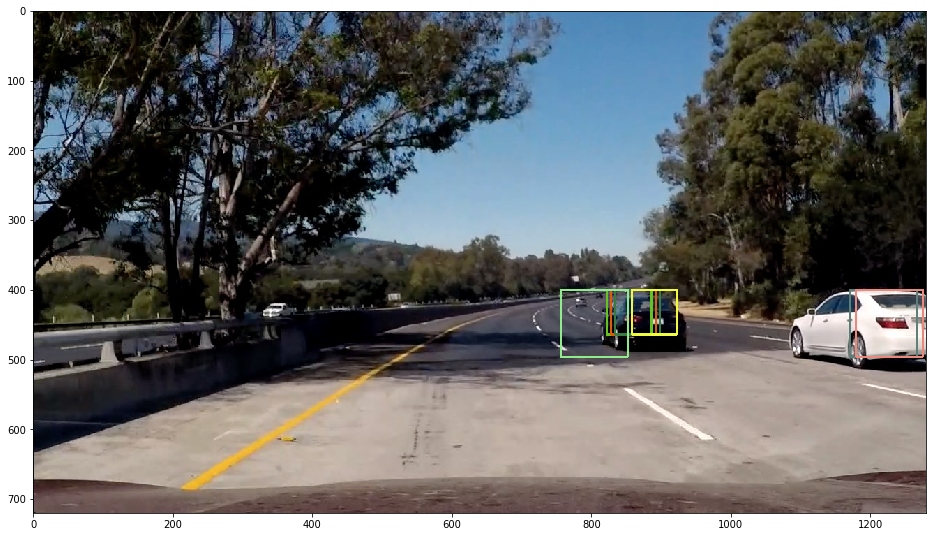

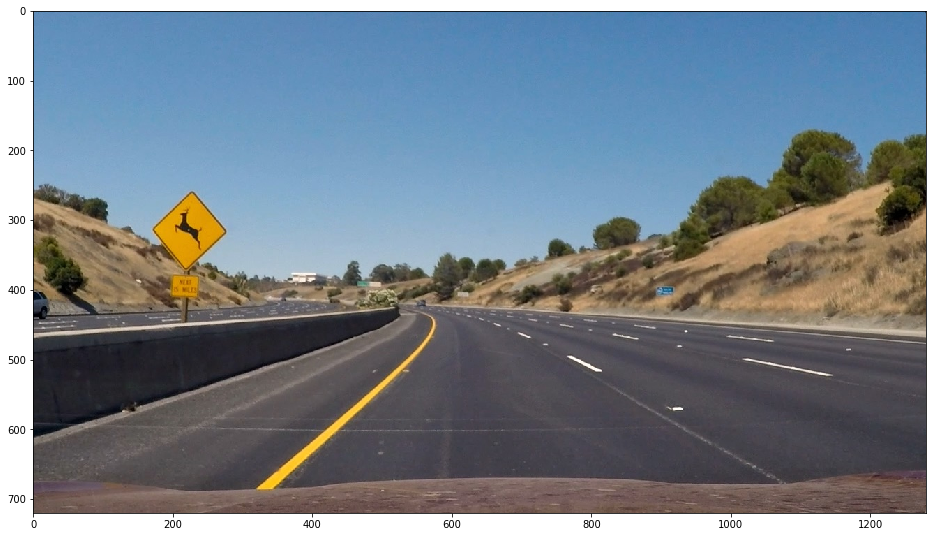

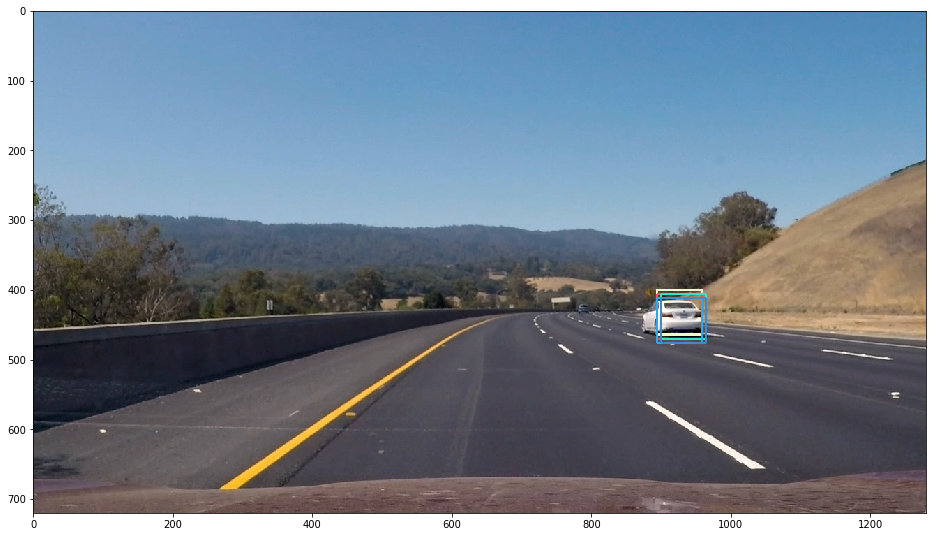

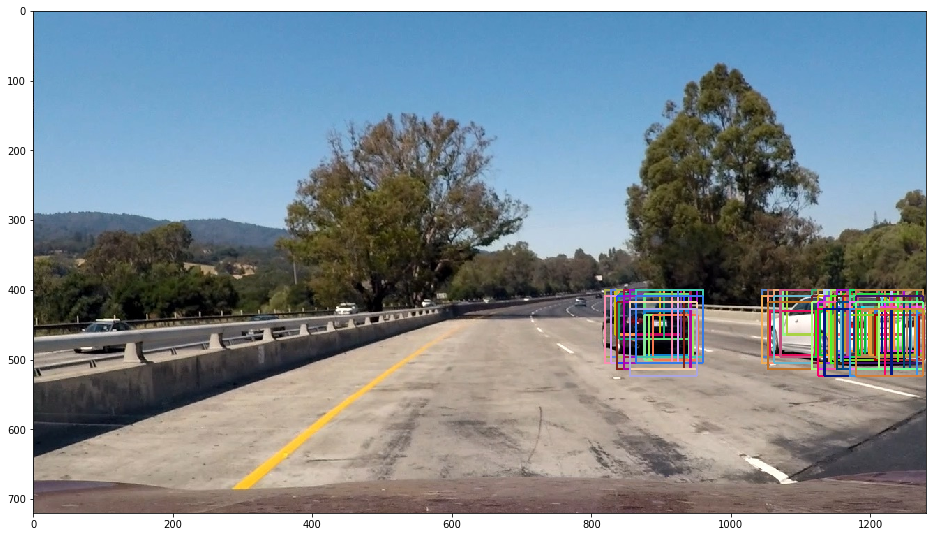

In [16]:
test_images = glob.glob('test_images/test*.jpg')

for test_img in test_images :
    ti = cv2.imread(test_img)
    hot_win, win_img = detect_cars(ti,search_space_window,clf1,X_scaler1,fcfg1,vis=True)
    print("# hot windows = ", len(hot_win))

### Heat Map

In [17]:
test_images = glob.glob('test_images/test*.jpg')

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

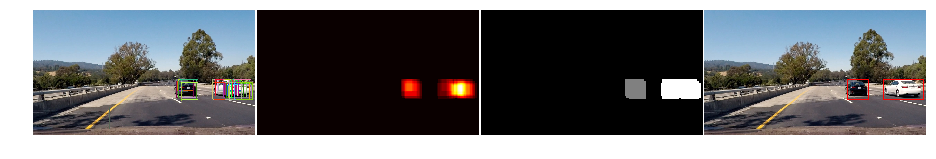

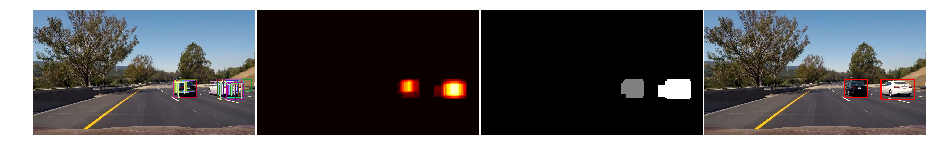

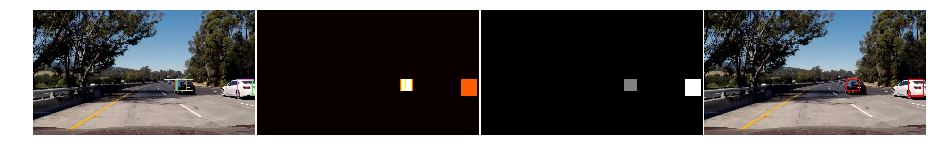

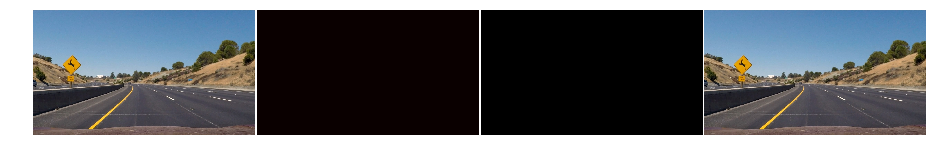

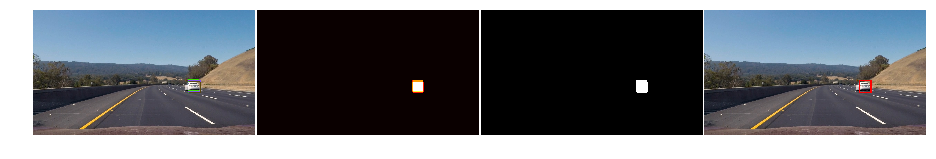

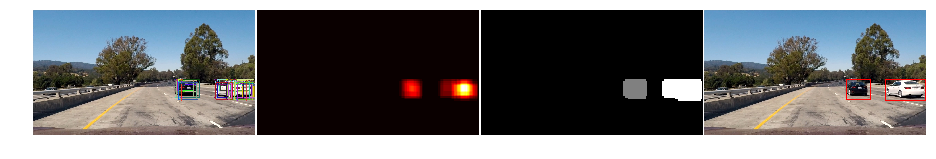

In [20]:
for test_img in test_images :
    ti = cv2.imread(test_img)
    heat = np.zeros_like(ti[:,:,0]).astype(np.float)
    box_list, window_img = detect_cars(ti,search_space_window,clf1,X_scaler1,fcfg1)
    
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying 
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(ti), labels)
    
    fig, axs = plt.subplots(1,4, figsize=(16, 11))
    fig.subplots_adjust(hspace = .1, wspace=.01)
    axs_set = [a.axis('off') for a in axs]
    axs[0].imshow(cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB))
    axs[1].imshow(heatmap, cmap='hot')
    axs[2].imshow(labels[0],cmap='gray')
    axs[3].imshow(cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB))

### Apply pipeline to video 

In [26]:
## Input Video
project_video = 'project_video.mp4'
test_video = 'test_video.mp4'

## Ouput
project_video_vehicle = 'project_video_vehicle.mp4'
test_video_vehicle = 'test_video_vehicle.mp4'

In [29]:
def vehicle_detection_pipeline(image):
    frame = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    heat = np.zeros_like(frame[:,:,0]).astype(np.float)
    box_list, window_img = detect_cars(frame,search_space_window,clf1,X_scaler1,fcfg1)
    
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying 
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

### Test video

In [30]:
## Process test_video
clip = VideoFileClip(test_video)#.subclip(0,0.5)
proc_clip = clip.fl_image(vehicle_detection_pipeline)
%time proc_clip.write_videofile(test_video_vehicle, audio=False)

[MoviePy] >>>> Building video test_video_vehicle.mp4
[MoviePy] Writing video test_video_vehicle.mp4


 97%|█████████▋| 38/39 [17:15<00:27, 27.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_vehicle.mp4 

CPU times: user 5min 7s, sys: 5min 26s, total: 10min 33s
Wall time: 17min 16s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_vehicle))

### Project Video

In [34]:
## Process project_video
clip = VideoFileClip(project_video)#.subclip(0,0.5)
proc_clip = clip.fl_image(vehicle_detection_pipeline)
%time proc_clip.write_videofile(project_video_vehicle, audio=False)

[MoviePy] >>>> Building video project_video_vehicle.mp4
[MoviePy] Writing video project_video_vehicle.mp4


100%|█████████▉| 1260/1261 [8:50:59<00:25, 25.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_vehicle.mp4 

CPU times: user 2h 38min 34s, sys: 2h 48min 27s, total: 5h 27min 1s
Wall time: 8h 51min


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_vehicle))